# Modeling

In [60]:
#Libs
import os
import warnings

import seaborn as sns
import pandas as pd
import numpy as np
import optuna
from optuna.samplers import TPESampler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from utils.features.build import build_distance, build_hour_group
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from ngboost import NGBRegressor

from sklearn.model_selection import cross_validate, cross_val_score
from dotenv import load_dotenv, find_dotenv
warnings.filterwarnings('ignore')

In [2]:
# Env variables and data
load_dotenv(find_dotenv())
DATA_INPUT_PATH = os.getenv('DATA_PROCESSED_PATH')
DATA_TRAIN_NAME = 'train_best_features'
DATA_TEST_NAME = 'test'
# Data
df_orders_train = pd.read_parquet(os.path.join(DATA_INPUT_PATH, DATA_TRAIN_NAME))
df_orders_test = pd.read_parquet(os.path.join(DATA_INPUT_PATH, DATA_TEST_NAME))

# 1) Modeling

In this step We'll try 3 approaches to solve the problem:
- Linear Regression 
- Random Forest 
- NGBoost 

With Linear Regression We intend to created a baseline to be beaten. We'll observe performance in terms of Mean Absolute Percentage Error and Proportion of overestimated predictions. 
The former metric will be better if It approaches 0, the latter will be better if When model gets It wrong, the model overestimates instead of underestimate. We wish this property because When the model underestimate, the order will be late, and It is better to be early than late.

In [3]:
X_train = df_orders_train.drop('total_minutes', axis=1)
y_train = df_orders_train['total_minutes']
all_columns = X_train.columns.tolist()

## 1.1) Preprocessing

In [4]:
# We will have 3 imputers: Median for some numerical, Mode for categorical and 0 for some numerical
median_impute_columns_indexes = [all_columns.index(x) for x in ['n_distinct_items', 'distance_km', 'found_rate']]
mode_impute_columns_indexes = [all_columns.index(x) for x in ['on_demand', 'hour_group']]
zero_impute_columns_indexes = [all_columns.index(x) for x in ['sum_kgs', 'sum_unities']]
cat_columns = df_orders_train.select_dtypes(include=['O']).columns.tolist()
cat_columns_indexes = [all_columns.index(x) for x in cat_columns]
num_columns = df_orders_train.drop('total_minutes', axis=1).select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns.tolist()
num_columns_indexes = [all_columns.index(x) for x in num_columns]
# Feature engineering steps
distance_transformer = FunctionTransformer(func=build_distance)
hour_group_transformer = FunctionTransformer(func=build_hour_group)
pipe_feature_engineering = Pipeline(steps=[('distance_transformer', distance_transformer),
                                           ('hor_group_transformer', hour_group_transformer)])
# Imputation Steps
impute_transformer = ColumnTransformer(
                     transformers=[
                         ('impute_median', SimpleImputer(strategy='median'), 
                                                        median_impute_columns_indexes),
                         ('impute_mode', SimpleImputer(strategy='most_frequent'),
                                                       mode_impute_columns_indexes),
                         ('impute_zero', SimpleImputer(strategy='constant', fill_value=0),
                                                       zero_impute_columns_indexes)
                                        ]
                                            )
# Categorical encoder step                                              
cat_column_transformer = ColumnTransformer(
                        transformers=[
                            ('cat_encoder', OneHotEncoder(handle_unknown='ignore'), cat_columns_indexes)
                        ])
preprocessor = Pipeline(steps=[('impute_transformer', impute_transformer),
                               ('cat_column_transformer', cat_column_transformer)
                            ])

## 1.2) Baseline

Our baseline will be a Linear Regression.

In [81]:
# Pipeline with preprocessor and Model
model_baseline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', TransformedTargetRegressor(LinearRegression(), func=np.log, inverse_func=np.exp))])

In [83]:
# Performing a 10-Fold cross validation to get an estimate for MAE and MAPE
df_baseline_cv_metrics = pd.DataFrame(cross_validate(model_baseline,
                                        X_train,
                                        y_train, 
                                        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                                        return_train_score=True, cv=10))

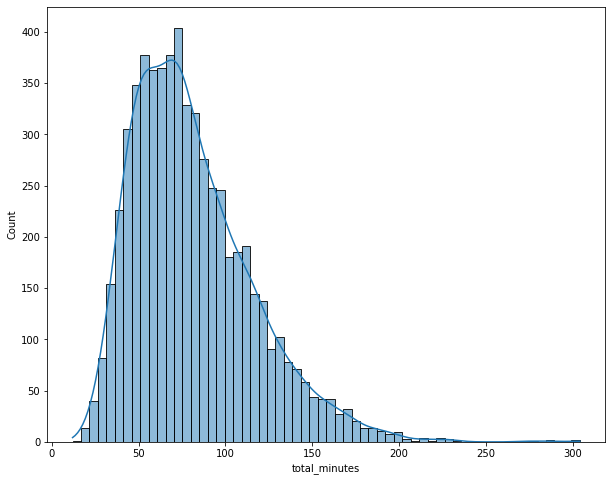

In [66]:
plt.figure(figsize=(10,8))
sns.histplot(y_train, kde=True)
plt.show()

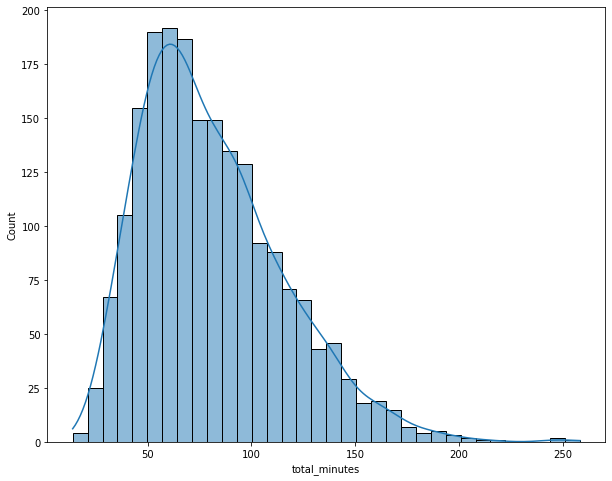

In [69]:
plt.figure(figsize=(10,8))
sns.histplot(y_test, kde=True)
plt.show()

In [84]:
df_baseline_cv_metrics

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.078190,0.010877,-22.298578,-14.850839,-0.296371,-0.205631
1,0.085778,0.013780,-21.793821,-14.927053,-0.294790,-0.207159
2,0.076346,0.012079,-22.947864,-14.744083,-0.296620,-0.205095
3,0.082463,0.012262,-21.395776,-14.842443,-0.274832,-0.206156
4,0.079930,0.014280,-22.419011,-14.671469,-0.304328,-0.203613
5,0.078715,0.012952,-23.091627,-14.643240,-0.289114,-0.204786
6,0.074512,0.012152,-23.683827,-14.759716,-0.308476,-0.204777
7,0.091686,0.012621,-24.091017,-14.585376,-0.308755,-0.203391
8,0.068913,0.011463,-22.215608,-14.884993,-0.296985,-0.207018
9,0.067342,0.010472,-24.239828,-14.543474,-0.312024,-0.202956


In [89]:
model_baseline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('impute_transformer',
                                  ColumnTransformer(transformers=[('impute_median',
                                                                   SimpleImputer(strategy='median'),
                                                                   [4, 6, 1]),
                                                                  ('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   [0, 5]),
                                                                  ('impute_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   [2, 3])])),
                      

In [90]:
print(f"Average MAPE - Cross Validation Test: {df_baseline_cv_metrics['test_neg_mean_absolute_percentage_error'].mean()}")
print(f"Standard Deviation of MAPE - Cross Validation Test: {df_baseline_cv_metrics['test_neg_mean_absolute_percentage_error'].std()}")

Average MAPE - Cross Validation Test: -0.2982294869504305
Standard Deviation of MAPE - Cross Validation Test: 0.011021323002233676


So, in average, the model is wrong by 32%. It means that for an order that will take 100 minutes to finish, It tends to predict either 132 or 68 minutes.

Also, We need to see if the predictions are higher or lower than the real value. It's better to overestimate the time, because the order will not be late. Let's check what happens more in our case, overestimate or underestimate.

In [91]:
y_train_baseline_predict = model_baseline.predict(X_train)
y_train_baseline_predict = y_train_baseline_predict
print(f'About {((y_train_baseline_predict >= y_train).sum())/len(y_train)*100}% of our predictions are higher than the real value')

About 48.3% of our predictions are higher than the real value


That is a good start. Now let's see if there is difference between MAPE for overestimated and underestimated orders 

In [92]:
list_y_train_baseline_predict = list(y_train_baseline_predict >= y_train)
overestimated_indexes_lr = [i for i in range(len(list_y_train_baseline_predict)) if list_y_train_baseline_predict[i]==True]
underestimated_indexes_lr = [i for i in range(len(list_y_train_baseline_predict)) if list_y_train_baseline_predict[i]==False]

In [98]:
# MAPE for overestimated predictions
print(f'On average a prediction is overestimated by {mean_absolute_percentage_error(y_train[overestimated_indexes_lr], y_train_baseline_predict[overestimated_indexes_lr])*100} %')

On average a prediction is overestimated by 25.99870242681672 %


In [99]:
print(f'On average a prediction is underestimated by {mean_absolute_percentage_error(y_train[underestimated_indexes_lr], y_train_baseline_predict[underestimated_indexes_lr])*100} %')

On average a prediction is underestimated by 15.833655355584927 %


## 1.2) Random Forest

As a challenger to the baseline, We will train a Random Forest Regressor. This model will have higher variance compared to Linear Regression and We'll focus on improving MAPE and also try to improve the rate of overestimated orders.

In [101]:
# Hyperparameter tuning using optuna 
def objective(trial):
    params = {'model__regressor__max_depth':trial.suggest_int('max_depth', 1, 10),
              'model__regressor__max_leaf_nodes':trial.suggest_int('max_leaf_nodes', 600, 1000),
              'model__regressor__n_estimators':trial.suggest_int('n_estimators', 30, 1000)}
    
    model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', TransformedTargetRegressor(RandomForestRegressor(random_state=123), func=np.log, inverse_func=np.exp))])
    model_rf.set_params(**params)   
    score = cross_val_score(model_rf, X_train, np.log(y_train), cv=5, scoring='neg_mean_squared_error')
    mse = score.mean()

    return mse
sampler = TPESampler(multivariate=True)
study = optuna.create_study(sampler=sampler, direction='maximize')
study.optimize(objective, n_trials=50)


[I 2021-12-07 09:59:54,686] A new study created in memory with name: no-name-4d0f9524-4f36-4931-9fc8-44d15914cdc1
[I 2021-12-07 09:59:59,706] Trial 0 finished with value: -0.15662451050879922 and parameters: {'max_depth': 2, 'max_leaf_nodes': 605, 'n_estimators': 466}. Best is trial 0 with value: -0.15662451050879922.
[I 2021-12-07 10:00:02,165] Trial 1 finished with value: -0.14564971069664795 and parameters: {'max_depth': 6, 'max_leaf_nodes': 757, 'n_estimators': 104}. Best is trial 1 with value: -0.14564971069664795.


In [16]:
model_rf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', RandomForestRegressor(random_state=123))])
model_rf['model'].set_params(**study.best_params)
df_rf_cv_metrics = pd.DataFrame(cross_validate(model_rf,
                                        X_train,
                                        y_train, 
                                        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                                        return_train_score=True, cv=10))

In [17]:
print(f"Average MAPE - Cross Validation Test: {df_rf_cv_metrics['test_neg_mean_absolute_percentage_error'].mean()}")
print(f"Standard Deviation of MAPE - Cross Validation Test: {df_rf_cv_metrics['test_neg_mean_absolute_percentage_error'].std()}")

Average MAPE - Cross Validation Test: -0.3465337538644138
Standard Deviation of MAPE - Cross Validation Test: 0.013841920079332753


In [68]:
#X_test = df_orders_test.loc[:, all_columns]
y_test = df_orders_test['total_minutes'] 

Average MAPE - Cross Validation Test: -0.33630988648780213
Standard Deviation of MAPE - Cross Validation Test: 0.01225231807773897


In [17]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('impute_transformer',
                                  ColumnTransformer(transformers=[('impute_median',
                                                                   SimpleImputer(strategy='median'),
                                                                   [4, 6, 1]),
                                                                  ('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   [0, 5]),
                                                                  ('impute_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   [2, 3])])),
                      

In [18]:
y_train_rf_predict = model_rf.predict(X_train)

In [20]:
(y_train_rf_predict > y_train).sum()/len(y_train)

0.5765

In [27]:
model_nb = Pipeline(steps=[('preprocessor', preprocessor), ('model', NGBRegressor(Base=DecisionTreeRegressor(max_depth=10, random_state=123), random_state=123))])
df_rf_nb_metrics = pd.DataFrame(cross_validate(model_nb,
                                        X_train,
                                        y_train, 
                                        scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error'], 
                                        return_train_score=True, cv=10))

[iter 0] loss=4.9734 val_loss=0.0000 scale=1.0000 norm=27.2982
[iter 100] loss=4.8368 val_loss=0.0000 scale=1.0000 norm=24.4095
[iter 200] loss=4.7695 val_loss=0.0000 scale=1.0000 norm=23.1024
[iter 300] loss=4.7155 val_loss=0.0000 scale=2.0000 norm=44.4338
[iter 400] loss=4.6818 val_loss=0.0000 scale=1.0000 norm=21.6454
[iter 0] loss=4.9758 val_loss=0.0000 scale=1.0000 norm=27.4284
[iter 100] loss=4.8374 val_loss=0.0000 scale=1.0000 norm=24.4559
[iter 200] loss=4.7670 val_loss=0.0000 scale=2.0000 norm=46.1839
[iter 300] loss=4.7131 val_loss=0.0000 scale=2.0000 norm=44.4369
[iter 400] loss=4.6772 val_loss=0.0000 scale=1.0000 norm=21.5953
[iter 0] loss=4.9579 val_loss=0.0000 scale=1.0000 norm=27.0679
[iter 100] loss=4.8186 val_loss=0.0000 scale=1.0000 norm=24.1490
[iter 200] loss=4.7515 val_loss=0.0000 scale=2.0000 norm=45.7265
[iter 300] loss=4.6966 val_loss=0.0000 scale=1.0000 norm=21.9764
[iter 400] loss=4.6603 val_loss=0.0000 scale=2.0000 norm=42.7516
[iter 0] loss=4.9748 val_loss=0

In [18]:
model_nb.fit(X_train, y_train)

[iter 0] loss=4.9693 val_loss=0.0000 scale=1.0000 norm=27.2385
[iter 100] loss=4.8716 val_loss=0.0000 scale=1.0000 norm=25.1732
[iter 200] loss=4.8323 val_loss=0.0000 scale=1.0000 norm=24.3716
[iter 300] loss=4.8077 val_loss=0.0000 scale=1.0000 norm=23.9096
[iter 400] loss=4.7845 val_loss=0.0000 scale=1.0000 norm=23.4771


Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('impute_transformer',
                                  ColumnTransformer(transformers=[('impute_median',
                                                                   SimpleImputer(strategy='median'),
                                                                   [4, 6, 1]),
                                                                  ('impute_mode',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   [0, 5]),
                                                                  ('impute_zero',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   [2, 3])])),
                      

In [13]:
df_rf_nb_metrics

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,7.157365,0.295477,-23.092406,-23.198072,-0.329407,-0.335853
1,6.816708,0.295548,-23.026899,-23.162978,-0.342997,-0.334735
2,6.687158,0.298408,-25.180214,-22.933261,-0.353435,-0.331868
3,6.991581,0.328202,-21.919185,-23.234642,-0.309969,-0.336513
4,7.290988,0.333993,-24.305392,-23.056168,-0.360849,-0.332950
5,8.134210,0.396101,-25.007872,-23.015520,-0.340256,-0.334293
6,9.621705,0.478240,-24.365086,-23.003119,-0.348459,-0.332707
7,13.759998,0.673369,-25.211166,-23.009897,-0.357825,-0.332920
8,17.313064,0.823399,-22.821717,-23.301326,-0.329703,-0.337566
9,19.036385,0.813878,-23.727438,-23.066166,-0.339377,-0.333739


In [20]:
X_train_preprocessed = model_nb['preprocessor'].transform(X_train)
y_train_prob = model_nb['model'].pred_dist(X_train_preprocessed).params

In [22]:
pd.DataFrame(y_train_prob)

,loc,scale
0,61.093169,28.814627
1,102.663713,38.867811
2,61.093169,28.814627
3,100.190359,28.648641
4,88.802990,31.342919
...,...,...
5995,67.793596,27.207726
5996,84.746860,28.648641
5997,67.915511,28.814627
5998,77.403340,28.068216


In [26]:
mean_absolute_percentage_error(y_train, y_train_prob['loc'])

0.3343651684048297

In [25]:
((y_train_prob['loc'] >= y_train).sum())/len(y_train)

0.585

In [ ]:
st.norm.interval(alpha=0.95, loc=np.mean(data), scale=st.sem(data))


## 1.3) Quantile Regression